In [45]:
#script 4  First order hunger
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
import math as m

# Define time settings
T = 150
dt = 0.005
t = np.arange(0, T, dt)
N  = t.size

F = np.zeros(N)
x = np.zeros(N)
x_dot = np.zeros(N)
ya = np.zeros(N)
ya_dot = np.zeros(N)
yb = np.zeros(N)
yb_dot = np.zeros(N)
mu_a = np.zeros(N)
mu_b = np.zeros(N)
phi_a = np.zeros(N)
phi_b = np.zeros(N)
mu_xa = np.zeros(N)
mu_xa_dot = np.zeros(N)
mu_xb = np.zeros(N)
mu_xb_dot = np.zeros(N)
u = np.zeros(N)
mu_v = np.zeros(N)
mu_v_dot = np.zeros(N)
x_int = np.zeros(N)

# precisions
#sensor 1
omega_az0 = np.ones(N)*5
omega_az1 = np.ones(N)*5

#sensor 2
omega_bz0 = np.ones(N)*5
omega_bz1 = np.ones(N)*5


# internal precisions
omega = np.ones(N)*10
omega_2 = np.ones(N)*10
omega_3= np.ones(N)*10
omega_4 = np.ones(N)*10

#learning rates
alpha = 1      
alpha_u = 1



#initiazation
mu_a[0] = 29
mu_xa[0] = 29
mu_b[0] = 29
mu_xb[0] = 29
x[0]= 29


for i in np.arange(0,N-1):
    #generative process of external position
    x_dot[i] = u[i]
    x[i+1] = x[i] + dt*x_dot[i]
  
    # if i == 0.4*N: 
    #     x[i+1] = x[i]
        
    #generative process of internal states     
    x_int = x[i+1]
    x_hung = x[i+1]


    #sensory states
    ya[i] = x[i]
    ya_dot[i] = x_dot[i]
    yb[i] = x[i] 
    yb_dot[i] = x_dot[i]


    if i >0.1*N:
        ya[i] = x[i] 
        yb[i] = x[i] #+ np.random.randn(1)*1


    if i > 0.3*N:
        ya[i] = x[i]
        yb[i] = x[i] + np.random.randn(1)*1

    if i >0.7*N:
        ya[i] = x[i] #+ np.random.randn(1)*0.3
        yb[i] = x[i] #+ np.random.randn(1)

    # set precisioon matrices for iteration
    PIa_z = np.diag([omega_az0[i],0.1*omega_az0[i]])
    PIb_z = np.diag([omega_bz0[i],0.1*omega_bz0[i]])
    PI_w = np.diag([1,1])

   
    #internal temperature estimation
    phi_a[i] = x_int# + np.random.rand(1)*0.1
    eps_1 = phi_a[i] - mu_a[i] 
    temp_prior = 30
    eps_2 = mu_a[i] - temp_prior


    #hunger estimation
    phi_b[i] = x_hung
    eps_3  = phi_b[i] - mu_b[i]
    hunger_prior = 29
    eps_4 = mu_b[i] - hunger_prior

    
    #external prediction errors
    e_xa = np.array([[mu_xa_dot[i]], [0]]) - (np.array([[-mu_xa[i]],[-mu_xa_dot[i]]]) + np.array([[mu_a[i]],[0]]))
    e_xb = np.array([[mu_xb_dot[i]], [0]]) - (np.array([[-mu_xb[i]],[-mu_xb_dot[i]]]) + np.array([[mu_b[i]],[0]]))
    e_ya = np.array([[ya[i]],[ya_dot[i]]]) - np.array([[mu_xa[i]],[mu_xa_dot[i]]])
    e_yb = np.array([[yb[i]],[yb_dot[i]]]) - np.array([[mu_xb[i]],[mu_xb_dot[i]]])

    
    #external depth estimation update
    dFdmu_xa = np.array([[1,1],[0,1]]).T.dot(np.dot(PI_w,e_xa)) - np.dot(np.identity(2),np.dot(PIa_z,e_ya)) 
    dmu_xa = np.array([[mu_xa_dot[i]], [0]]) - alpha*dFdmu_xa
    mu_xa[i+1] = mu_xa[i] + dt*dmu_xa[0]
    mu_xa_dot[i+1] = mu_xa_dot[i] +dt*dmu_xa[1]

    #external depth estimation update
    dFdmu_xb = np.array([[1,1],[0,1]]).T.dot(np.dot(PI_w,e_xb)) - np.dot(np.identity(2),np.dot(PIa_z,e_yb)) 
    dmu_xb = np.array([[mu_xb_dot[i]], [0]]) - alpha*dFdmu_xb
    mu_xb[i+1] = mu_xb[i] + dt*dmu_xb[0]
    mu_xb_dot[i+1] = mu_xb_dot[i] +dt*dmu_xb[1]


    #Free Energy MOET NOG WORDEN VERBETERD!!!!!!!!
    # F[i] =0.5*(e_xa.T.dot(PI_w.dot(e_xa)) + e_ya.T.dot(PIa_z).dot(e_ya) +  e_yb.T.dot(PIb_z).dot(e_yb) + eps_1*omega[i]*eps_1 + eps_2*omega_2[i]*eps_2 - np.log(np.linalg.det(PI_w)) - np.log(np.linalg.det(PIa_z)) - np.log(np.linalg.det(PIb_z)))

    #causal depth state update
    # dFdmu_a = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_xa)) + np.array([[omega_2[i],0]]).dot(np.array([[eps_2],[0]])) - np.array([[omega[i]],[0]]).dot(np.array([[eps_1],[0]]))
    dFdmu_a = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_xa)) + np.array([[omega_2[i]*eps_2],[0]] ) - np.array([[omega[i]*eps_1],[0]] ) 
    dmu_a = -alpha*dFdmu_a[0]
    mu_a[i+1] = mu_a[i] + dt*dmu_a[0]

    #causal hunger state update
    # dFdmu_b = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_xb)) + np.array([[omega_4[i],0]])*np.array([[eps_4],[0]]) - np.array([[omega_3[i]],[0]])*np.array([[eps_3],[0]])
    dFdmu_b = np.array([[-1,0],[0,0]]).T.dot(np.dot(PI_w,e_xb)) + np.array([[omega_4[i]*eps_4],[0]])- np.array([[omega_3[i]*eps_3],[0]] )
    dmu_b = -alpha*dFdmu_b[0]
    mu_b[i+1] = mu_b[i] + dt*dmu_b[0]



    #Action updating
    u_dot = -np.array([0,1]).dot(PIa_z).dot(e_ya) -np.array([0,1]).dot(PIb_z).dot(e_yb) 
    u[i+1] = u[i] + alpha_u*dt*u_dot
    

    
    # precision updating
    # dPI_w = alpha_w*0.5*(inv(PI_w) - np.diag(e_x.flatten())**2)
    # PI_w = PI_w + dt*dPI_w

    alpha_1 = 1
    alpha_2 = 1
    alpha_3 = 1
    alpha_4 = 1
    alpha_za = 1
    alpha_zb = 1

    domega = alpha_1*0.5*(1/omega[i] - eps_1**2)
    domega_2 = alpha_2*0.5*(1/omega_2[i]- eps_2**2)
    omega[i+1] = omega[i] + dt*domega
    omega_2[i+1] = omega_2[i] + dt*domega_2

    
    domega_3 = alpha_3*0.5*(1/omega_3[i] - eps_3**2)
    domega_4 = alpha_4*0.5*(1/omega_4[i]- eps_4**2)
    omega_3[i+1] = omega_3[i] + dt*domega_3
    omega_4[i+1] = omega_4[i] + dt*domega_4

    dPIa_z = alpha_za*0.5*(inv(PIa_z) - np.diag(e_ya.flatten())**2)
    PIa_z = PIa_z + dt*dPIa_z
    omega_az0[i+1] = PIa_z[0,0]
    omega_az1[i+1] = PIa_z[1,1]

    dPIb_z = alpha_zb*0.5*(inv(PIb_z) - np.diag(e_yb.flatten())**2)
    PIb_z = PIb_z + dt*dPIb_z
    omega_bz0[i+1] = PIb_z[0,0]
    omega_bz1[i+1] = PIb_z[1,1]


    #just so the graph wont show zero at the end
    phi_a[i+1] = x[i+1]
    phi_b[i+1] = x[i+1]



In [31]:
print(dmu_a)
print(PIa_z)
print(PIb_z)

[0.00121035]
[[13.18680332  0.        ]
 [ 0.          1.00249924]]
[[1.01913916 0.        ]
 [0.         1.0024963 ]]


In [ ]:
# print(eps_1, "eps1")
# print(eps_2, "eps2")
# print(e_x, "e_x")

# print(e_ya, "e_ya  ")
# print(e_yb, "e_yb")

# print(PI_w, "PI_w")
# print(PIa_z, "PIa_z" )
# print(PIb_z, "PIb_z")
# print(omega[-1], "omega")
# print(omega_2[-1], "omega_2")

# print(F[-2], "F")

plt.figure()
plt.plot(u)

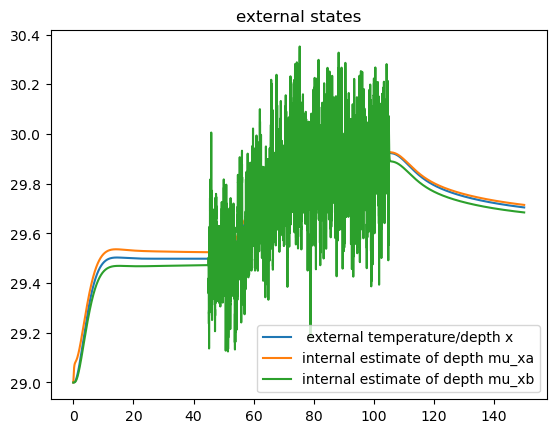

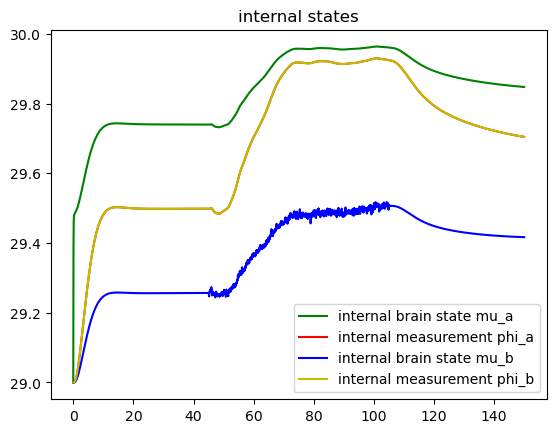

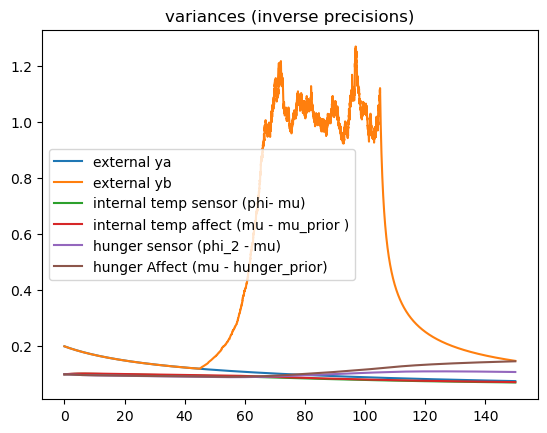

In [46]:
#plot 3

plt.figure()
plt.plot(t, x, label = " external temperature/depth x")
plt.plot(t,mu_xa, label = "internal estimate of depth mu_xa")
plt.plot(t,mu_xb, label = "internal estimate of depth mu_xb")
plt.title("external states")
plt.legend()

plt.figure()
plt.plot(t, mu_a, label = "internal brain state mu_a" , color = "g")
plt.plot(t, phi_a, label = "internal measurement phi_a", color = "r")
plt.plot(t, mu_b, label = "internal brain state mu_b" , color = "b")
plt.plot(t, phi_b, label = "internal measurement phi_b", color = "y")
plt.title("internal states")
plt.legend()
# plt.plot(mu_dot)

plt.figure()
plt.plot(t,1/omega_az0, label =  "external ya")
plt.plot(t,1/omega_bz0, label = "external yb")
plt.plot(t, 1/omega, label = "internal temp sensor (phi- mu)")
plt.plot(t, 1/omega_2, label = "internal temp affect (mu - mu_prior )")
plt.plot(t, 1/omega_3, label = "hunger sensor (phi_2 - mu)")
plt.plot(t, 1/omega_4, label = "hunger Affect (mu - hunger_prior)")
plt.title("variances (inverse precisions)")

plt.legend()

